<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/MaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Cargamos librerías

In [11]:
!pip install mtcnn
from mtcnn import MTCNN
import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
from PIL import Image
import cv2
import timeit
import matplotlib.pyplot as plt
from bounding_box import resizeBoundingBox
from predictor import predict

#### 2. Variables de configuración

In [0]:
IMG_WIDTH = 160 # ancho de la imagen
IMG_HEIGHT = 160 # alto de la imagen
BBOX_PERCENTAGE = 0.05 # porcentage de ampliación del bounding box

#### 3. Carga de imagen original

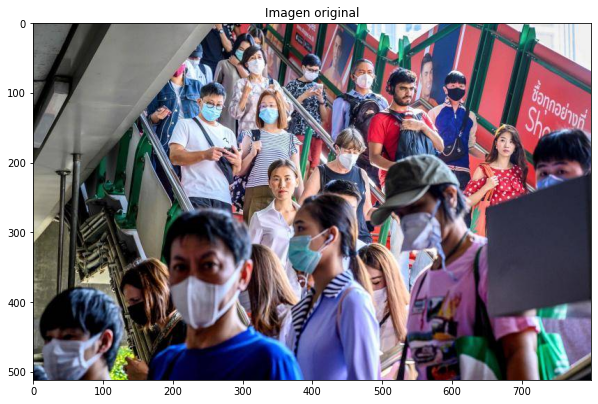

In [26]:
img = cv2.imread('test3.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_color = cv2.resize(img_color, (1600, 800))
plt.figure(figsize=(10, 10))
plt.title("Imagen original")
plt.imshow(img_color)
plt.show()

#### 4. Cargamos modelo detector de rostros y mascarillas

In [0]:
# Detector de rostros (FaceNet)
detector = MTCNN()
# Detector de mascaras (MaskNet)
model = tf.keras.models.load_model('mask_net.hdf5')
classes = ['no_mask', 'mask']

#### 5. Detectamos si las personas tienen mascarillas o no (Prueba con imágenes)

In [0]:
start_time = timeit.default_timer()
faces_mtcnn = detector.detect_faces(img_color)
img_color_temp = img_color.copy()
index = 1
for face in faces_mtcnn:
    face['idx'] = index
    bbox = face['box']
    confidence = face['confidence']
    if confidence >= 0.7:
      x, y, w, h = resizeBoundingBox((img_color.shape[1], img_color.shape[0]), bbox, .05)
      img_face_slice = img_color[y:(y + h),x:(x + w), :]
      img_resize = cv2.resize(img_face_slice, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_AREA)
      pred, proba = predict(model, classes, np.expand_dims(img_resize[:,:,::-1], axis = 0))
      color = (0,255, 0) if pred == 'mask' else (255,0,0)
      cv2.rectangle(img_color_temp, (x, y), (x + w, y + h), color, 3)
      cv2.putText(img_color_temp, pred.replace("_", " ").capitalize(), (x-2, y-7), cv2.FONT_HERSHEY_SIMPLEX, .9, color, 2)
    index = index + 1
end_time = timeit.default_timer()
print("Total time:", (end_time - start_time))
plt.figure(figsize=(12, 12))
plt.imshow(img_color_temp)
plt.show()

#### 6. Detectamos si las personas tienen mascarillas o no (Prueba con video)

In [0]:
video = cv2.VideoCapture('video_prueba.mp4')
W = None
H = None
writer = None

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]

	# Inicializar el writer
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output_video.avi', fourcc, 30, (W, H), True)

  img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  faces_mtcnn = detector.detect_faces(img_color)
  img_color_temp = img_color.copy()
  index = 1
  for face in faces_mtcnn:
      face['idx'] = index
      bbox = face['box']
      confidence = face['confidence']
      if confidence >= 0.5:
        x, y, w, h = resizeBoundingBox((img_color.shape[1], img_color.shape[0]), bbox, .05)
        img_face_slice = img_color[y:(y + h),x:(x + w), :]
        img_resize = cv2.resize(img_face_slice, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_AREA)
        pred, proba = predict(model, classes, np.expand_dims(img_resize[:,:,::-1], axis = 0))
        color = (0,255, 0) if pred == 'mask' else (255,0,0)
        cv2.rectangle(img_color_temp, (x, y), (x + w, y + h), color, 3)
        cv2.putText(img_color_temp, pred.replace("_", " ").capitalize(), (x-2, y-7), cv2.FONT_HERSHEY_SIMPLEX, .9, color, 2)
      index = index + 1
  if writer is not None:
    writer.write(img_color_temp[:,:,::-1])      

if writer is not None:
  writer.release()

video.release()